In [1]:
###importing the needed libraries
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import convolve2d
from scipy.interpolate import RectBivariateSpline
from scipy.interpolate import griddata
from scipy.interpolate import interp2d
from scipy.ndimage import convolve, gaussian_filter
from scipy.ndimage import map_coordinates

# Q1: functions

In [2]:
###functions from the pdf!
def flowToColor(flow, maxflow=None, verbose=False):
    '''
    args
        flow (numpy array) height x width x 2
    return
        img_color (numpy array) height x width x 3
    '''

    UNKNOWN_FLOW_THRESH = 5e2
    eps = 1e-6

    height, widht, nBands = flow.shape

    if nBands != 2:
        exit('flowToColor: image must have two bands')

    u = flow[:, :, 0]
    v = flow[:, :, 1]

    maxu = -999
    maxv = -999

    minu = 999
    minv = 999
    maxrad = -1

    # fix unknown flow
    idxUnknown = (abs(u) > UNKNOWN_FLOW_THRESH) | (abs(v) > UNKNOWN_FLOW_THRESH)
    u[idxUnknown] = 0
    v[idxUnknown] = 0

    maxu = max(maxu, u.max())
    minu = min(minu, u.min())

    maxv = max(maxv, v.max())
    minv = min(minv, v.min())

    rad = np.sqrt(u ** 2 + v ** 2)
    maxrad = max(maxrad, rad.max())

    if verbose:
        print('max flow: %.4f flow range: u = %.3f .. %.3f; v = %.3f .. %.3f\n' %
              (maxrad, minu, maxu, minv, maxv))

    if maxflow is not None:
        if maxflow > 0:
            maxrad = maxflow

    u = u / (maxrad + eps)
    v = v / (maxrad + eps)

    img = computeColor(u, v)

    # unknown flow
    # IDX = repmat(idxUnknown, [1, 1, 3])
    img[idxUnknown] = 0

    return img

def computeColor(u, v, cast_uint8=True):
    '''
    args
        u (numpy array) height x width
        v (numpy array) height x width
        cast_uint8 (bool) set False to have image range 0-1 (np.float32)
    return
        img_color (numpy array) height x width x 3
    '''

    nanIdx = np.isnan(u) | np.isnan(v)
    u[nanIdx] = 0
    v[nanIdx] = 0

    colorwheel = makeColorwheel()
    ncols = colorwheel.shape[0]

    rad = np.sqrt(u ** 2 + v ** 2)

    a = np.arctan2(-v, -u)/np.pi

    fk = (a + 1) / 2 * (ncols - 1)  # -1~1 maped to 1~ncols

    k0 = np.floor(fk).astype(int)  # 1, 2, ..., ncols

    k1 = k0 + 1
    k1[k1 == ncols + 1] = 1

    f = fk - k0

    height, width = u.shape
    img = np.zeros((height, width, 3), np.float32)
    nrows = colorwheel.shape[1]
    for i in range(nrows):
        tmp = colorwheel[:, i]
        col0 = tmp[k0.reshape(-1)] / 255
        col1 = tmp[k1.reshape(-1)] / 255
        col = col0.reshape(height, width) * (1 - f) + \
              col1.reshape(height, width) * f

        idx = rad <= 1
        col[idx] = 1 - rad[idx] * (1 - col[idx])  # increase saturation with radius

        col[np.logical_not(idx)] *= 0.75  # out of range

        img[:, :, i] = col * (1 - nanIdx)

    if cast_uint8:
        img = np.floor(img * 255).astype(np.uint8)
    return img


def makeColorwheel():
    '''
    color encoding scheme
    adapted from the color circle idea described at
    http://members.shaw.ca/quadibloc/other/colint.htm
    '''

    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR

    colorwheel = np.zeros((ncols, 3))  # r g b

    col = 0
    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.floor(255*np.array(range(RY))/RY)
    col = col+RY

    # YG
    colorwheel[col:col+YG, 0] = 255 - np.floor(255*np.array(range(YG))/YG)
    colorwheel[col:col+YG, 1] = 255
    col = col+YG

    # GC
    colorwheel[col:col+GC, 1] = 255
    colorwheel[col:col+GC, 2] = np.floor(255*np.array(range(GC))/GC)
    col = col+GC

    # CB
    colorwheel[col:col+CB, 1] = 255 - np.floor(255*np.array(range(CB))/CB)
    colorwheel[col:col+CB, 2] = 255
    col = col+CB

    # BM
    colorwheel[col:col+BM, 2] = 255
    colorwheel[col:col+BM, 0] = np.floor(255*np.array(range(BM))/BM)
    col = col+BM

    # MR
    colorwheel[col:col+MR, 2] = 255 - np.floor(255*np.array(range(MR))/MR)
    colorwheel[col:col+MR, 0] = 255

    return colorwheel

In [3]:
def compute_temporal_derivative(image1, image2, kernel_size=(3, 3), sigma=1):
    # smoothing images
    image1_smoothed = cv2.GaussianBlur(image1, kernel_size, sigma)
    image2_smoothed = cv2.GaussianBlur(image2, kernel_size, sigma)
    # Compute temporal derivative by subtracting
    temporal_derivative = image2_smoothed - image1_smoothed

    return temporal_derivative

In [4]:
### computing optical flow and visualizing Ix,Iy,It 
def myFlow(img1, img2, window_size, threshold):
    
    #Compute spatial derivatives using a five-tap filter

    h = np.array([1, -8, 0, 8, -1]) / 12.0
    # Flip the filter
    h_flipped = np.flip(h)
    image = img1
    # Pad the image with zeros
    padded_image = np.pad(image, ((2, 2), (2, 2)), mode='constant', constant_values=0)


    # Initialize empty arrays for derivatives
    Ix = np.zeros_like(image, dtype=np.float32)
    Iy = np.zeros_like(image, dtype=np.float32)

    # Apply the filter
    for i in range(2, padded_image.shape[0] - 2):
        for j in range(2, padded_image.shape[1] - 2):
            Ix[i-2, j-2] = np.sum(padded_image[i-2:i+3, j] * h_flipped)
            Iy[i-2, j-2] = np.sum(padded_image[i, j-2:j+3] * h_flipped)
    

    plt.show()
    # Compute temporal derivative (It)
    It = compute_temporal_derivative(img1, img2, kernel_size=(3, 3), sigma=1)
    
    
    # Displaying results to make sure its correct
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(Ix,cmap='gray')
    plt.title('Ix')

    plt.subplot(1, 3, 2)
    plt.imshow(Iy,cmap='gray')
    plt.title('Iy')

    plt.subplot(1, 3, 3)
    plt.imshow(It, cmap='gray')
    plt.title('It')
    

    #Initialize empty matrices u and v and the binary map for valid flow
    u = np.zeros_like(img1,dtype=float)
    v = np.zeros_like(img1,dtype=float)
    valid_flow = np.zeros_like(img1, dtype=bool)

    #compute flow for each pixel
    half_window = window_size // 2
    for y in range(half_window, img1.shape[0] - half_window):
        for x in range(half_window, img1.shape[1] - half_window):
            # Extract the local window around each pixel
            Ix_window = Ix[y - half_window:y + half_window + 1, x - half_window:x + half_window + 1]
            Iy_window = Iy[y - half_window:y + half_window + 1, x - half_window:x + half_window + 1]
            It_window = It[y - half_window:y + half_window + 1, x - half_window:x + half_window + 1]

            # Compute A matrix
            A = np.array([
                [np.sum(Ix_window**2), np.sum(Ix_window * Iy_window)],
                [np.sum(Ix_window * Iy_window), np.sum(Iy_window**2)]
            ])

            # Check if the matrix is invertible
            if np.linalg.det(A) != 0 and np.min(np.linalg.eigvals(A)) > threshold:
                # Computing u and v using the pseudo inverse
                uv = -np.linalg.inv(A) @ np.array([np.sum(Ix_window * It_window), np.sum(Iy_window * It_window)])

                #filling u,v,valid_flow
                u[y, x] = uv[0]
                v[y, x] = uv[1]
                valid_flow[y, x] = True
    return u, v, valid_flow


# Q1:  Calculating U , V and Valid_flow

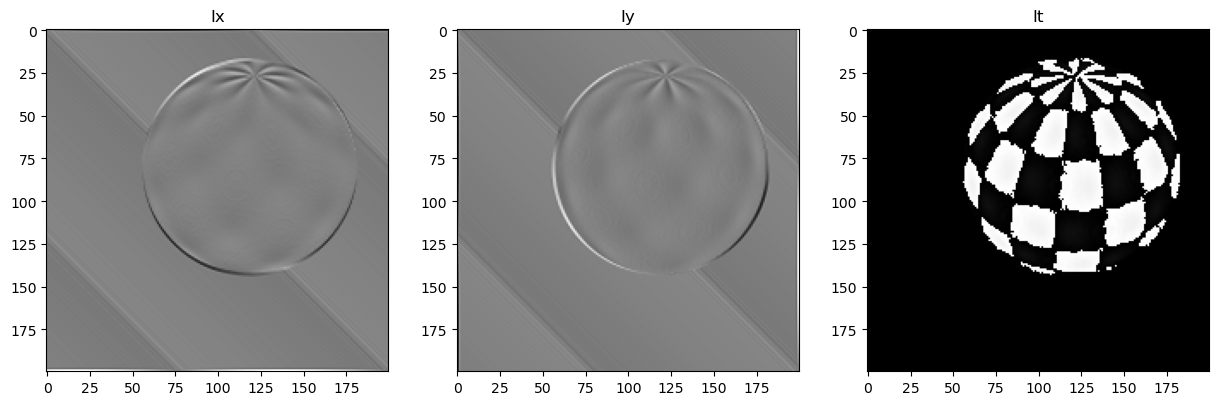

In [5]:
# img1 = cv2.imread("Sequences/corridor/bt_0.png",cv2.IMREAD_GRAYSCALE)
# img2 = cv2.imread("Sequences/corridor/bt_1.png",cv2.IMREAD_GRAYSCALE)
# img1 = cv2.imread("Sequences/synth/synth_0.png",cv2.IMREAD_GRAYSCALE)
# img2 = cv2.imread("Sequences/synth/synth_1.png",cv2.IMREAD_GRAYSCALE)
img1 = cv2.imread("Sequences/sphere/sphere_0.png",cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread("Sequences/sphere/sphere_1.png",cv2.IMREAD_GRAYSCALE)
window_length = 3
threshold = 0.00000001
u, v, valid_flow = myFlow(img1, img2, window_length, threshold)

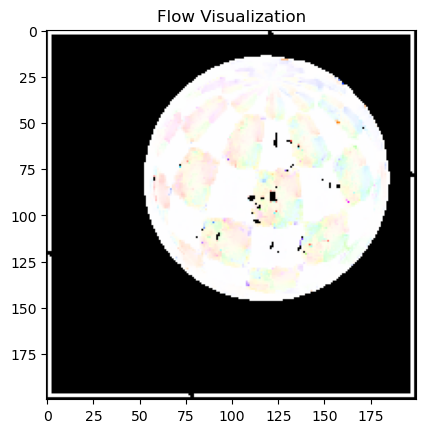

In [6]:
flow_color = flowToColor(np.dstack((u, v)))

# Mask invalid flow values
flow_color[~valid_flow] = [0, 0, 0]

# Display the flow visualization
plt.imshow(flow_color)
plt.title('Flow Visualization')
plt.show()

###  window size is to the size of the local neighborhood around a pixel that is considered estimating the motion among frames. it is a square window centered around the pixel of interest. 
### Smaller window lengths are better for rapid changes. the effect is a trade-off between capturing details of motion and providing good estimates.

# Q2: functions

In [7]:
def myWarp(img, u, v):
    height, width = img.shape[:2]
    y, x = np.mgrid[0:height, 0:width]

    # Apply the flow (backward warp)
    warped_x = x - u
    warped_y = y - v

    # Interpolate
    warped_img = cv2.remap(img, warped_x.astype(np.float32), warped_y.astype(np.float32), interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)

    return warped_img

# Q2: warpping andd visualize the result 

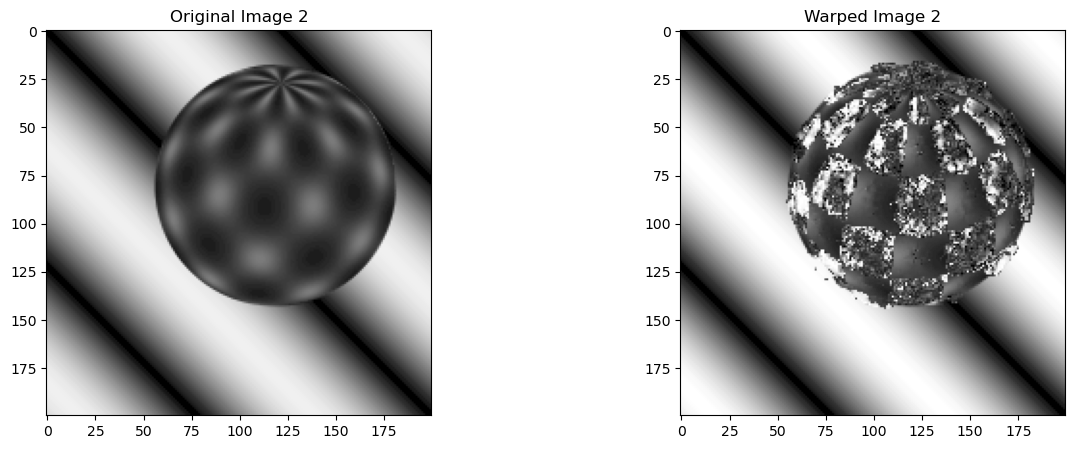

In [8]:
warped_img2 = myWarp(img2, u, v)
# Display the original and warped images for comparison
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title('Original Image 2')

plt.subplot(1, 2, 2)
plt.imshow(warped_img2, cmap='gray')
plt.title('Warped Image 2')

plt.show()

# Q2: Running images in a loop

<IPython.core.display.Javascript object>


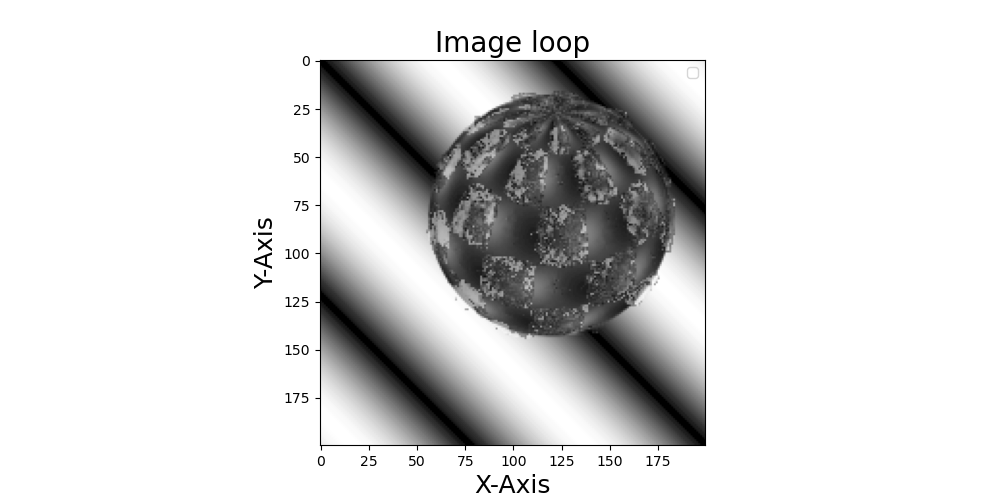

In [9]:
%matplotlib notebook

# Interactive update using matplotlib equivalent
figure, ax = plt.subplots(figsize=(10, 5))

# Display the original and warped images
im1 = ax.imshow(img1, cmap='gray')
im2 = ax.imshow(warped_img2, cmap='gray', alpha=0.5)

# Set up the figure
plt.xlabel("X-Axis", fontsize=18)
plt.ylabel("Y-Axis", fontsize=18)
plt.title("Image loop", fontsize=20)
plt.legend(["Original", "Warped"])

# Update images interactively
for value in range(150):
    if value % 2 == 1:
        update_warped_img2 = warped_img2
        update_warped_img2_rgb = cv2.cvtColor(update_warped_img2, cv2.COLOR_BGR2RGB)
    else:
        update_warped_img2 = img1
        update_warped_img2_rgb = cv2.cvtColor(update_warped_img2, cv2.COLOR_BGR2RGB)
        

    im2.set_array(update_warped_img2)
    figure.canvas.draw()
    figure.canvas.flush_events()
    time.sleep(0.1)

# Q3: functions

In [10]:
def harris_corner_detector(image, k=0.04, threshold=0.01, max_keypoints=40):
    # Compute gradients using Sobel operator
    Ix = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    Iy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

    # Compute products of gradients
    Ixx = Ix * Ix
    Iyy = Iy * Iy
    Ixy = Ix * Iy

    # Compute sums of products with Gaussian smoothing
    window_size = 5
    k_size = (window_size, window_size)
    Ixx = cv2.GaussianBlur(Ixx, k_size, 0)
    Iyy = cv2.GaussianBlur(Iyy, k_size, 0)
    Ixy = cv2.GaussianBlur(Ixy, k_size, 0)

    # Compute Harris response
    det = Ixx * Iyy - Ixy * Ixy
    trace = Ixx + Iyy
    harris_response = det - k * (trace ** 2)

    # Apply non-maximum suppression
    local_maxima = cv2.dilate(harris_response, None) == harris_response
    harris_response *= local_maxima

    # Threshold the response to get corner points
    corner_points = np.where(harris_response > threshold * harris_response.max())

    # Combine x and y coordinates into a list of [x, y]
    corners = np.column_stack((corner_points[1], corner_points[0]))

    # Sort corners based on Harris response and select the top ones
    sorted_corners = corners[np.argsort(harris_response[corner_points])[::-1]]
    selected_corners = sorted_corners[:max_keypoints]

    return selected_corners



In [11]:
def optical_flow(prev_frame, next_frame, keypoints, window_size=(15, 15)):
    u = np.zeros_like(keypoints[:, 0, 0])
    v = np.zeros_like(keypoints[:, 0, 1])

    Ix = cv2.Sobel(prev_frame, cv2.CV_64F, 1, 0, ksize=5)
    Iy = cv2.Sobel(prev_frame, cv2.CV_64F, 0, 1, ksize=5)

    for i, (x, y) in enumerate(keypoints[:, 0]):
        # Ensure the window remains within the image boundaries
        y_start, y_end = max(0, int(y) - window_size[0] // 2), min(prev_frame.shape[0], int(y) + window_size[0] // 2 + 1)
        x_start, x_end = max(0, int(x) - window_size[1] // 2), min(prev_frame.shape[1], int(x) + window_size[1] // 2 + 1)

        patch_prev = prev_frame[y_start:y_end, x_start:x_end]
        patch_next = next_frame[y_start:y_end, x_start:x_end]

        It = patch_next - patch_prev
        Ixt = cv2.Sobel(patch_prev, cv2.CV_64F, 1, 0, ksize=5)
        Iyt = cv2.Sobel(patch_prev, cv2.CV_64F, 0, 1, ksize=5)

        A = np.array([[np.sum(Ixt * Ixt), np.sum(Ixt * Iyt)],
                      [np.sum(Ixt * Iyt), np.sum(Iyt * Iyt)]])
        B = -np.array([np.sum(Ixt * It), np.sum(Iyt * It)])

        if np.linalg.det(A) != 0:
            uv = np.linalg.solve(A, B)
            u[i], v[i] = uv

    return u, v

In [12]:
def process_image_sequence(sequence_path, num_frames):
    keypoints_list = []

    # Load the initial frame
    initial_frame = cv2.imread(sequence_path + "hotel.seq0.png", cv2.IMREAD_GRAYSCALE)

    # Process each frame in the sequence
    for frame_number in range(1, num_frames):
        # Load the next frame
        next_frame = cv2.imread(sequence_path + f"hotel.seq{frame_number}.png", cv2.IMREAD_GRAYSCALE)

        # Apply Harris Corner Detector
        keypoints = harris_corner_detector(initial_frame)

        # Convert keypoints to numpy array
        keypoints_np = np.array([keypoints], dtype=np.float32)

        # Calculate optical flow to get new keypoints on the next frame
        u, v = optical_flow(initial_frame, next_frame, keypoints_np)

        # Interpolate subpixel values
        x_interp = keypoints[:, 0] + u
        y_interp = keypoints[:, 1] + v

        # Discard keypoints outside the frame or near image borders
        valid_mask = np.logical_and.reduce([
            x_interp >= 0,
            y_interp >= 0,
            x_interp < next_frame.shape[1],
            y_interp < next_frame.shape[0]
        ])

        # Update keypoints based on optical flow and filtering
        updated_keypoints = np.column_stack((x_interp[valid_mask], y_interp[valid_mask]))

        # Append the updated keypoints to the list
        keypoints_list.append(updated_keypoints)

        # Update the initial frame for the next iteration
        initial_frame = next_frame

    return keypoints_list

# Q3: visualize the result

In [13]:
# Load your image sequence
num_frames = 50
img_sequence = [cv2.imread(f"Hotel Sequence/hotel.seq{i}.png") for i in range(num_frames)]

# Initialize canvas with the first frame as the background
canvas = img_sequence[0].copy()

sequence_path = "Hotel Sequence/"

keypoint_paths = process_image_sequence(sequence_path, 50)
for i, frame in enumerate(img_sequence):
    for path in keypoint_paths[i-1]:
        x, y = path.ravel()
        cv2.circle(frame, (int(x), int(y)), 3, (0, 0, 255), 1)  # Draw red circles on tracked keypoints
        cv2.circle(canvas, (int(x), int(y)), 3, (0, 0, 255), 1)  # Update canvas with red keypoints

    cv2.imshow("Tracked Keypoints", frame)
    cv2.waitKey(100)  # Adjust the wait time as needed for visualization

# Display the canvas with all tracked keypoints
cv2.imshow("All Tracked Keypoints in Red", canvas)
cv2.waitKey(0)
cv2.destroyAllWindows()